In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys

In [18]:
"""
Implementing the alignment function
The whole idea is that, given an embedding for the encoder and decoder, the aalignment function outputs 
a scalar raiting the alignment. So, the shapes of v, W, and U should be such that the output is a scalar
"""

import torch.nn.functional as F

# def the size of the input and output vectors of the attention mechanism
EMBED_DIM= 100

# these need to be sized in such a way that matrix multiplication yields a scalar
# otherwise, they're just general learnable parameters. Different alignment
# functions might have different parameters. For instance, "attention is all you
# need" uses a projection head that generates a query, key, and value, which are
# used in a different self-alignment function. this can allign vectors of different lengths
encoder_embedding_dim= EMBED_DIM*2
decoder_embedding_dim= EMBED_DIM

U_attention= torch.rand(EMBED_DIM, encoder_embedding_dim)
W_attention= torch.rand(decoder_embedding_dim, EMBED_DIM)
v_attention= torch.rand(1,EMBED_DIM)

def alignment_func(s, h, W=W_attention, U=U_attention, v=v_attention):
    """
    s: si-1, from the paper, the previous decoder state
    h: hj, from the paper, an input embedding
    W,U,v: trainable parameters
    
    calculates v*tanh(W*s + U*h), should return a scalar alpha
    """
    
    v1= torch.matmul(W, s)
    v2= torch.matmul(U, h)
    v3= torch.tanh(v1 + v2)
    
    return torch.matmul(v, v3)

# testing the alignment function between one embedded word and another
# dividing by value to get them in a good range for tanh
s= torch.rand(decoder_embedding_dim)/50
h= torch.rand(encoder_embedding_dim)/50
alignment_func(s, h)

tensor([43.9654])

In [19]:
# An example output of the alignment function. A scalar, which corresponds to a specific input-output pair

In [20]:
"""
defining attention, wich is a list of softmaxed alignment scores for all input
embeddings (hj) given the previous decoder embedding (si-1). This is equivilent
to a row of the attention matrix, hence the name of the function.
"""

def compute_attention_row(s, hs, W=W_attention, U=U_attention, v=v_attention):
    """
    computes alignments for all h values given s

    s is a vector of length embedding size
    hs is a tensor of shape (sequence length, embedding size)
    the output is a vector of sequence length
    """
    
    return F.softmax(torch.cat([alignment_func(s, h, W, U, v) for h in hs]), 0)

# testing the computation of an allignment row between the previous decoder
# embedding and all encoder embeddings
compute_attention_row(torch.rand(decoder_embedding_dim)/50, torch.rand(10,encoder_embedding_dim)/50)

tensor([0.0397, 0.0896, 0.0791, 0.1762, 0.0843, 0.0715, 0.0424, 0.1164, 0.0935,
        0.2073])

In [ ]:
# A single attention vector for a given output position.

In [23]:
"""
Defining the attention module
This is implemented in such a way where the computation of attention creates a traceable gradient, 
allowing the U, W, and v parameters to be updated through back propagation.
"""

# defining the input dimension from the encoder (h) and decoder (s)
encoder_embedding_dim= 10
decoder_embedding_dim= 20

# defining an example sequence length
sequence_length= 15

class Attention(nn.Module):
    """
    -computes an alignment for all encoder embeddings
    -constructs a context vector using those embeddings
    -outputs that context vector
    """
    
    def __init__(self, embed_dim=EMBED_DIM, encoder_embedding_dim=encoder_embedding_dim,
                 decoder_embedding_dim=decoder_embedding_dim):
        super(Attention, self).__init__()
        
        # learnable attention parameters 
        self.U= nn.Parameter(torch.rand(embed_dim, encoder_embedding_dim), requires_grad=True)
        self.W= nn.Parameter(torch.rand(embed_dim, decoder_embedding_dim), requires_grad=True)
        self.v= nn.Parameter(torch.rand(1, embed_dim), requires_grad=True)
        self.encoder_embedding_dim= encoder_embedding_dim
        
        if torch.cuda.is_available():
            self.cuda()
            
    def forward(self, s, hn):
        """
        computes a batch of context vectors given a current the all encoder
        embeddings and the current decoder embedding
        """
        # defining a tensor consisting of a context vector for each batch
        weights= compute_attention_row(s, hn, W=self.W, U=self.U, v=self.v)
        
        return torch.sum(hn * weights[:, None], axis=0)


print('==== Testing Attention ====')
# testing if the attention mechanism can support different sequence lengths and embedding dimensions
test_attention= Attention()

# defining previous decoder state
s= torch.rand(decoder_embedding_dim)/50
# defining input embeddings
hn= torch.rand(sequence_length, encoder_embedding_dim)/50

test_attention(s, hn).shape

==== Testing Attention ====


torch.Size([10])

In [ ]:
# Creates a context vector of length 10. This makes sense, as the input embeddings are of length 10, 
# and the output of this attention technique is a context vector which is the weighted sum of all the 
# input embeddings.

 34%|███▍      | 271/800 [00:06<00:13, 39.85it/s]


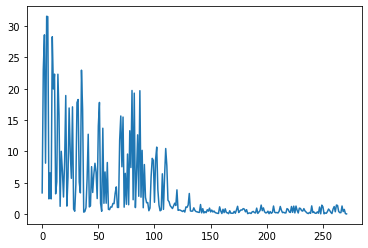

In [52]:
""" 
Training Attention

Essentially, this generates random X/Y pairs, and trains the model to predict
each output given the previous correct output and all of the inputs.

This is a proof of concept. In reality using minibatches, better initializations, and
stochastically providing the true previous output occasionally would probably improve
convergence and generalizability.
"""
import random
from tqdm import tqdm

min_len= 5
max_len= 20

test_attention= Attention(20,2,2)
loss_fn= nn.MSELoss()
optimizer= torch.optim.SGD(test_attention.parameters(), lr=1e-3, momentum=0.9)
lr_phase= 0

# training on some number of random sequences
batch_losses= []

for i in tqdm(range(800)):
    
    # generating x and y
    x= []
    y= []
    for j in range(random.randint(min_len,max_len)):
        x.append([j+1, j+2])
        y.append([j+1, j+2])
            
    random.shuffle(x)
    x= np.array([[0,1]] + x).astype(np.float32)
    x= torch.from_numpy(x)
    y= np.array([[0,1]] + y).astype(np.float32)
    y= torch.from_numpy(y)
    
    # iterating over all training examples (given s predict s+1)
    s_in= x[0]
    sample_losses= []
    for j in range(2, len(x)):
        
        y_this= y[j]
        
        optimizer.zero_grad()
        s_out= test_attention(s_in, x)
        
        loss= loss_fn(s_out, y_this)
        sample_losses.append(loss.detach())
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        s_in= torch.clone(y_this).detach()
        
    batch_loss= np.mean(sample_losses)
    batch_losses.append(batch_loss)
    
    # hacking together a simple learning rate scheduler
    if (batch_loss< 0.05 and lr_phase== 0):
        optimizer= torch.optim.SGD(test_attention.parameters(), lr=1e-4, momentum=0.9)
        lr_phase += 1
        
    # stopping training when loss is good enough
    if (batch_loss< 0.05):
        break
        
plt.plot(batch_losses)

In [ ]:
# Using the following code, we can generate a randomly shuffled sequence and ask our attention model 
# to sort it.

input: 
[[ 0.  1.]
 [ 2.  3.]
 [10. 11.]
 [ 7.  8.]
 [ 9. 10.]
 [ 6.  7.]
 [ 8.  9.]
 [ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 4.  5.]]
output: 
[[ 1.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [ 9. 10.]]


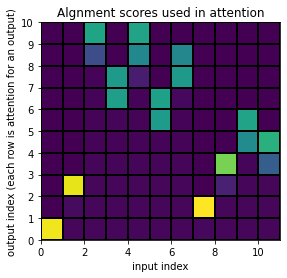

In [69]:
"""
Visualizing alignment
"""

# generating x
x= []
for j in range(1, random.randint(min_len, max_len)):
    x.append([j, j+1])

random.shuffle(x)

x= np.array([[0,1]] + x).astype(np.float32)
x= torch.from_numpy(x)

# extracting learned parameters for generating alignment visual
W= test_attention.W
U= test_attention.U
v= test_attention.v

s= x[0]
y_hat= []
rows= []

# predicting the next element in the sequence.
# skipping over the trivia first, and not predicting one after the last.
for _ in range(0, len(x)-1):
    
    # computing attention weights for this output, for visualization purposes
    row= list(compute_attention_row(s, x, W=W, U=U, v=v).detach().numpy())
    rows.append(row)
    
    # predicting what should be in this location.
    with torch.no_grad():
        s= torch.round(test_attention(s, x))
        
    y_hat.append(list(s))
    
# converting to numpy arrays
y_hat= np.array(y_hat)
x_p= np.array(x)

# print inouts and predicted outputs
print('input: ')
print(x_p)
print('output: ')
print(y_hat)

# generating attention matrix plot
from matplotlib.ticker import MaxNLocator

alignments= np.array(rows)
plt.pcolormesh(alignments, edgecolors='k', linewidth=2)
ax= plt.gca()
ax.set_aspect('equal')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Algnment scores used in attention')
plt.ylabel('output index (each row is attention for an output)')
plt.xlabel('input index')
plt.show()

In [ ]:
# https://towardsdatascience.com/attention-from-alignment-practically-explained-548ef6588aa4
# https://towardsdatascience.com/multi-headed-self-attention-by-hand-d2ce1ae031db